In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap


RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
shap.initjs()

# Introduction:

DataSet: https://www.kaggle.com/uciml/pima-indians-diabetes-database

The goal of this project is to develop a Machine Learning model capable of predicting if a woman has diabetes, with some parameters, such as glucose in the last blood exam or insulin. This model will be a classifier and it will be tested through some different alternatives to check which one has the best outcome. 

Dependent variable: Outcome

Examples of Independent Variables: Life expectancy and Poverty rates

In [2]:
diabetes = pd.read_csv('diabetes.csv')

diabetes

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


# First look at the database

In [3]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


We can learn through the info function that there are no null values in the database, therefore we don't need to address any solution to the missing values

In [4]:
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


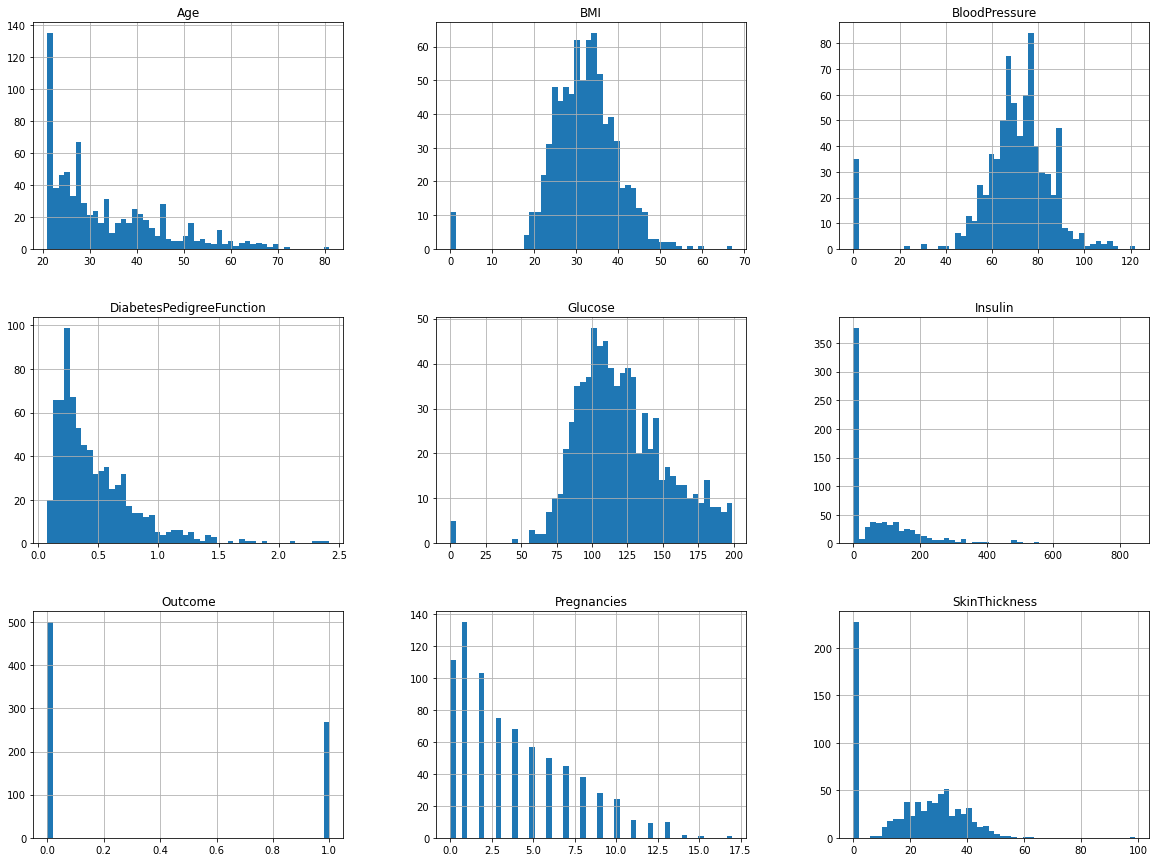

In [5]:
diabetes.hist(bins=50, figsize=(20, 15))
plt.show()

### Missing Values

As we can see, the dabatabase don't have null values, but, there are multiple 0s. This would make sense in some cases, such as pregnancies, but in others, for example, inslulin and blood pressure. This situations needs to be addressed. The approach we'll take will be by replacing the mean values of the whole column to the missing value. 

# Dividing in Train Test

We will be making the division of the train and test set stratifically. This is due to the fact that the parameter "Diabetes Pedigree Function" is believed to have a huge impact on the outcome, therefore, we believe that the train and the test sets should have the same proportion. Also, as we have a small amount of samples (m = 768) this type of separation can be usefull since, if we were to not to use it, the proportion would be unequal.

In [8]:
q = diabetes['DiabetesPedigreeFunction'].quantile([0.2,0.4,0.6,0.8]).values

def check_pedigree(x):
    result = 0
    for val in q:
        if x > val:
            result += 1
        else:
            break
    return result
diabetes['pedigree_cat'] = diabetes['DiabetesPedigreeFunction'].apply(check_pedigree)
diabetes['pedigree_cat'].value_counts(True)

3    0.200521
2    0.200521
0    0.200521
4    0.199219
1    0.199219
Name: pedigree_cat, dtype: float64

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(
    n_splits=1,
    test_size=0.2,
    random_state=RANDOM_SEED,
)
for train_index, test_index in split.split(diabetes, diabetes['pedigree_cat']):
    strat_train_set = diabetes.loc[train_index]
    strat_test_set = diabetes.loc[test_index]

In [10]:
print(strat_train_set['pedigree_cat'].value_counts(True), '\n', strat_test_set['pedigree_cat'].value_counts(True))

4    0.200326
3    0.200326
2    0.200326
0    0.200326
1    0.198697
Name: pedigree_cat, dtype: float64 
 3    0.201299
2    0.201299
1    0.201299
0    0.201299
4    0.194805
Name: pedigree_cat, dtype: float64


As we can see, both test and train has the same proportions of values.

In [11]:
#Now we need to drop the created column
strat_train_set.drop(['pedigree_cat'], axis=1, inplace=True)
strat_test_set.drop(['pedigree_cat'], axis=1, inplace=True)

# Exploratory analysis

In [12]:
diabetes_train = strat_train_set.copy()

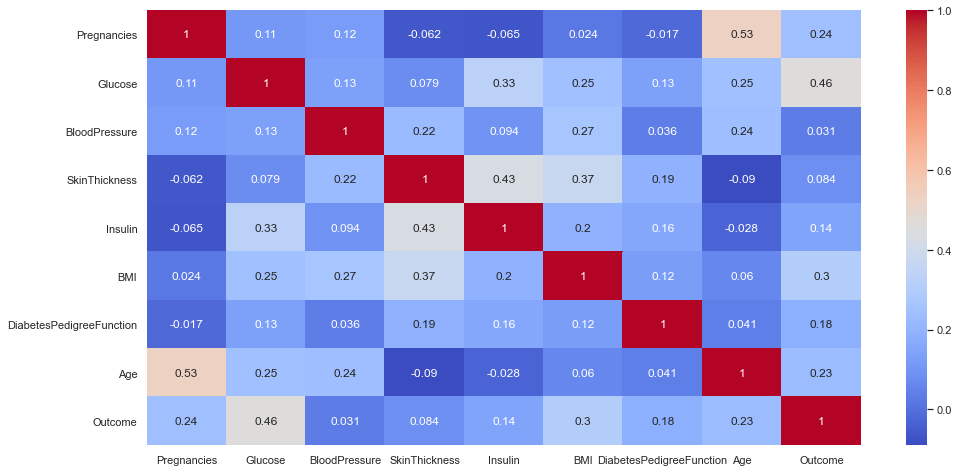

In [13]:
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
corr = diabetes_train.corr()
sns.heatmap(corr,annot=True,cmap="coolwarm")

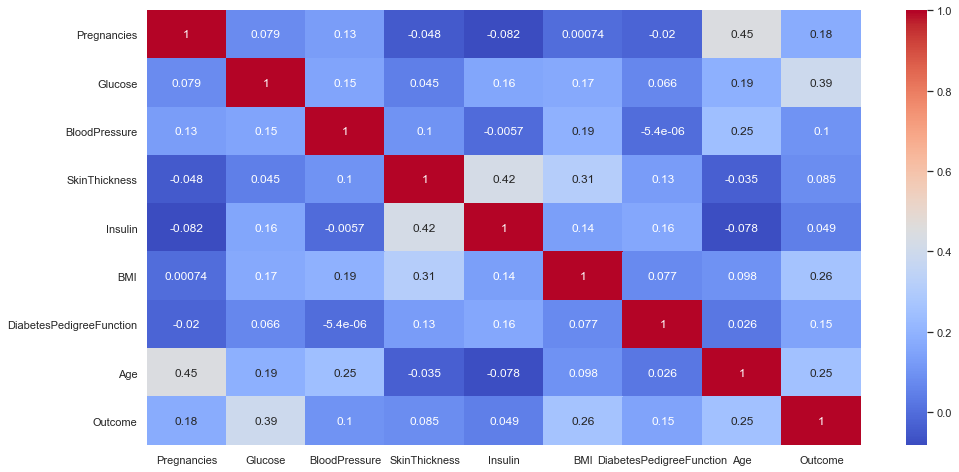

In [14]:
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
corr = diabetes_train.corr(method='kendall')
sns.heatmap(corr,annot=True,cmap="coolwarm")

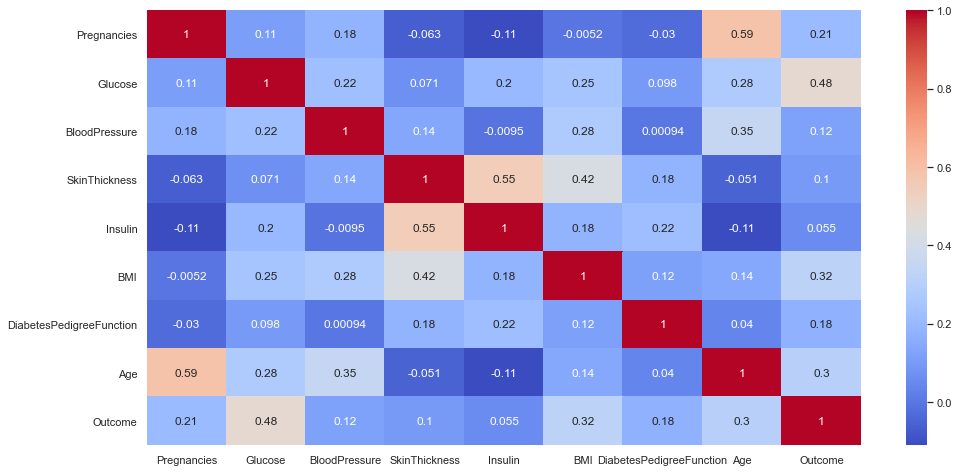

In [15]:
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
corr = diabetes_train.corr(method='spearman')
sns.heatmap(corr,annot=True,cmap="coolwarm")

As we can see, the kendall correlation seems to be the one with the higher values for the outcome relation with other variables. This indicates that the relationship between the outcome and other variables may not be linear.

We can see that the correlation between age and pregnancies is the highest. Also, the outcome appears to have some kind of relation with glucose.

# Separating Independent and Dependent Variables

In [16]:
#Replacing the 0s with Nan so that SimpleImputer can operate
strat_train_set = strat_train_set.replace(to_replace={
             'BloodPressure':{0:np.nan}, 
             'Insulin':{0:np.nan},
             'SkinThickness':{0:np.nan},
             'BMI':{0:np.nan},
             'Glucose':{0:np.nan},
                 })
strat_train_set.dropna(subset=['BMI', 'BloodPressure', 'Glucose'], inplace = True)

diabetes_train = strat_train_set.drop('Outcome', axis=1)

diabetes_labels = strat_train_set['Outcome'].copy()

In [17]:
y_test=strat_test_set['Outcome']
strat_test_set.drop(['Outcome'], axis=1, inplace=True)


## Replacing Invalid values

In [19]:
from sklearn.impute import SimpleImputer


# #Replacing the 0s with Nan so that SimpleImputer can operate
# diabetes_in = diabetes_train.replace(to_replace={
#              'BloodPressure':{0:np.nan}, 
#              'Insulin':{0:np.nan},
#              'SkinThickness':{0:np.nan},
#              'BMI':{0:np.nan},
#              'Glucose':{0:np.nan},
#                  })
# diabetes_in.dropna(subset=['BMI', 'BloodPressure', 'Glucose'], inplace = True)
diabetes_in = diabetes_train

imputer = SimpleImputer(strategy='median')

imputer.fit(diabetes_in)

SimpleImputer(strategy='median')

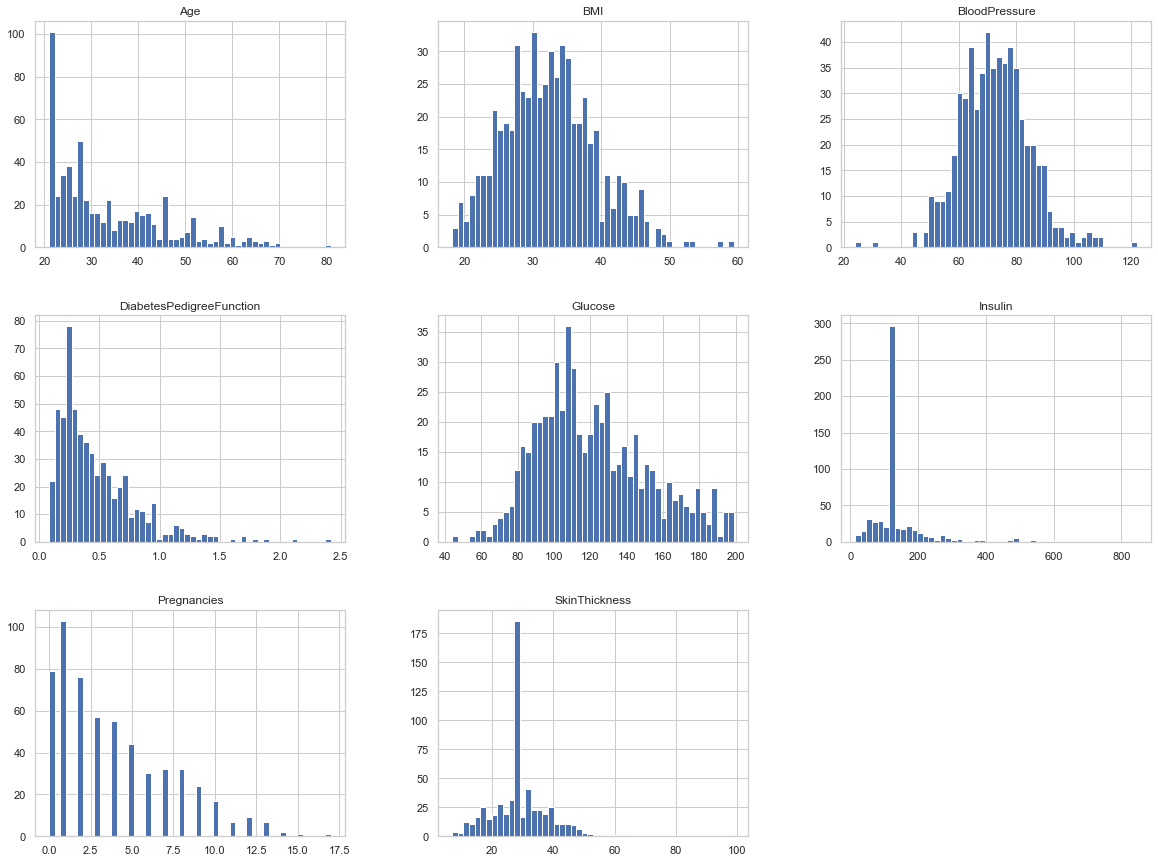

In [20]:
temp = imputer.transform(diabetes_in)

diabetes_inputed = pd.DataFrame(temp, columns=diabetes_in.columns)

diabetes_inputed.hist(bins=50, figsize=(20, 15))
plt.show()

As we can see, there are no more 0s values, although we have huge peeks in the mean values of some parameters, this makes the database much better

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(diabetes_inputed)

temp = scaler.transform(diabetes_inputed)

diabetes_train = pd.DataFrame(temp, columns=diabetes_inputed.columns)
diabetes_train

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.614986,1.460390,0.119633,-0.024251,-0.174598,-0.863342,-0.513290,2.715500
1,2.374415,-0.691978,0.943900,0.412259,-0.435312,-0.358499,0.054719,1.040666
2,1.201462,-0.431085,-0.210074,-0.024251,-0.174598,-0.284258,1.496351,-0.047977
3,-0.851206,-0.822425,4.076116,-0.024251,-0.174598,-1.486971,-0.812730,-0.550427
4,-0.851206,-1.115929,-1.034341,0.848769,-0.768137,0.710580,0.119546,-0.969136
...,...,...,...,...,...,...,...,...
571,2.081177,1.101662,0.284487,-0.133378,0.063926,0.131495,2.724980,1.459374
572,0.614986,-1.181153,0.449340,-0.024251,-0.174598,-0.180319,-0.272503,0.705699
573,-1.144444,-0.626755,-0.704634,1.830917,-0.734854,1.215422,0.079415,-1.052878
574,1.787939,0.384206,-0.374927,-0.024251,-0.174598,-0.803949,-0.695423,0.203248


# Binary Classifier

In [22]:
from sklearn.linear_model import SGDClassifier

# Existe aleatoriedade dentro do SGDClassifier, por isso o argumento
# random_state=RANDOM_SEED.
sgd_clf = SGDClassifier(
    max_iter=500,
    tol=1e-3,
    random_state=RANDOM_SEED,
)
sgd_clf.fit(diabetes_train, diabetes_labels)

SGDClassifier(max_iter=500, random_state=42)

### Cross Validation

Before we test the performance of the Model "SGD Classifier" we should know the proportions of the target variable. The reason for this is because if the data has a proportion of 80% of people who have diabetes and 20% who haven´t, and the Classifier has an accuracy of 80%, the model would be as bad as one who just guess constanly "user with diabetes".

In [23]:
diabetes_labels.value_counts(True)

0    0.668403
1    0.331597
Name: Outcome, dtype: float64

In [24]:
import time
from sklearn.model_selection import cross_val_score

t1 = time.process_time()
res = cross_val_score(
    sgd_clf,
    diabetes_train,
    diabetes_labels,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
)
t2 = time.process_time()

print(res)

[0.67708333 0.78645833 0.6875    ]


Here we see that the model had an accuracy around 68%, which may seem ok (but not good enough). But, when it compare the porportion of people who has diabetes in the data, we realize that this model was almost as bad as one who keeps only guessing "people who don't have diabetes". Therefore, we need to improve.

### Confusion Matrix

In [25]:
from sklearn.metrics import confusion_matrix

sgd_clf.fit(diabetes_train, diabetes_labels)
y_train_pred = sgd_clf.predict(diabetes_train)
mat = confusion_matrix(diabetes_labels, y_train_pred)
mat

array([[302,  83],
       [ 82, 109]])

Although the accuracy wasn´t really good, it is important to understand in which cases the model has missed. With the confusion matrix it was learned that there was a lot of false negatives. This is unacceptable in this scneario, since the model should never overlook people with diabetes because it is a health situation and people can be harmed if they are not properly diagnosed. Therefore, the model should focous on having a high Recall.

In [26]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, diabetes_train, diabetes_labels, cv=3, n_jobs=-1)

In [27]:
mat = confusion_matrix(diabetes_labels, y_train_pred)
mat

array([[310,  75],
       [ 88, 103]])

### Precision Recall

In [28]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(diabetes_labels, y_train_pred))
print(recall_score(diabetes_labels, y_train_pred))

0.5786516853932584
0.5392670157068062


As we can see, the Recall is actually low, and now it is important to adjust this value to make it more accpetable.

In [29]:
y_scores = cross_val_predict(
    sgd_clf,
    diabetes_train,
    diabetes_labels,
    cv=3,
    method="decision_function",
    n_jobs=-1,
)

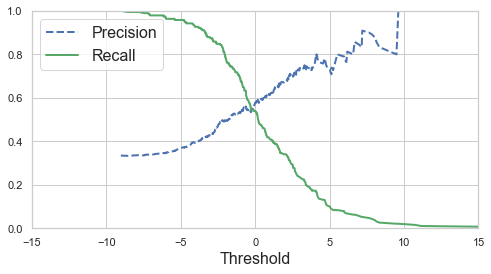

In [30]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(diabetes_labels, y_scores)

plt.figure(figsize=(8, 4))

plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)

plt.xlabel("Threshold", fontsize=16)
plt.legend(loc="upper left", fontsize=16)
plt.xlim([-15, 15])
plt.ylim([0, 1])
plt.show()

With this graph it is possible to discover a value of Threshold that increases the Recall, which is -5. With this, it is possible to adjust the results for the aim of decreasing false negatives

In [31]:
y_train_pred_90 = (y_scores > -5)

In [32]:
print('Precision: {}'.format(precision_score(diabetes_labels, y_train_pred_90)))
print('Recall: {}'.format(recall_score(diabetes_labels, y_train_pred_90)))

Precision: 0.3689516129032258
Recall: 0.9581151832460733


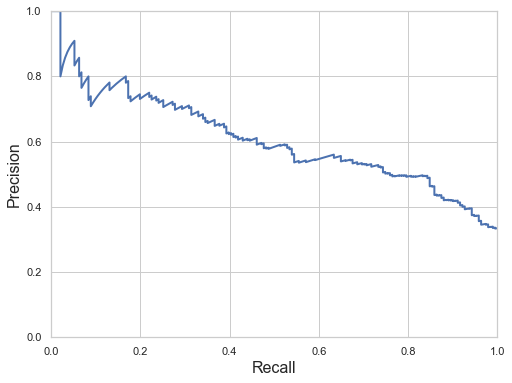

In [33]:
plt.figure(figsize=(8, 6))

plt.plot(recalls, precisions, "b-", linewidth=2)

plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.axis([0, 1, 0, 1])

plt.show()

It is possible to see that when the Recall is increased, the Precision has the opposite reaction. In the current scneario, this is not a problem, because the goal is to just increase the Recall.

#### ROC Curve

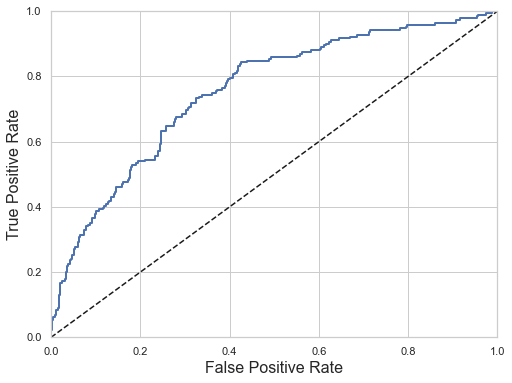

In [34]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(diabetes_labels, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.show()

In [35]:
from sklearn.metrics import accuracy_score


sgd_clf.fit(diabetes_train, diabetes_labels)


y_pred=sgd_clf.predict(strat_test_set)

acc = accuracy_score(y_test, y_pred)
print('Regressão logistica: acurácia = {:.2f}'.format(acc))

Regressão logistica: acurácia = 0.39


For the diabetes problem, the ideal format of this curve is when the area below the curve is high thus making the curve closer to the upper left corner. With the SGD classifier, the curve obtained does not match the ideal shape. This concept is known as ROC curve and what is desired in the present study is a high sensitivity, or true positive rate, meaning a high recall.

# Random Forest Classifier

In [36]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)


t1 = time.process_time()
res = cross_val_score(
    forest_clf,
    diabetes_train,
    diabetes_labels,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
)
t2 = time.process_time()

print(res)

[0.796875   0.8125     0.73958333]


Through the cross val score, it seems that this classifier has a better perfomance than the SDG.

In [37]:


# O "score" vai ser a probabilidade de que a amostra seja da classe positiva.
y_probas_forest = cross_val_predict(
    forest_clf,
    diabetes_train,
    diabetes_labels,
    cv=3,
    method="predict_proba",
    n_jobs=-1,
)

# Gambiarra para desviar do bug #9589 introduzido no Scikit-Learn 0.19.0:
y_scores_forest = y_probas_forest[:, 1]

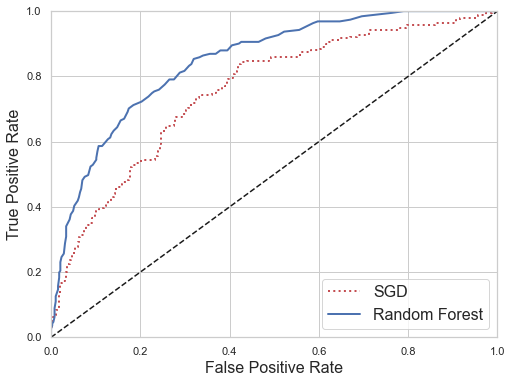

In [38]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(
    diabetes_labels,
    y_scores_forest,
)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "r:", linewidth=2, label="SGD")
plt.plot(fpr_forest, tpr_forest, linewidth=2, label="Random Forest")
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [39]:
from sklearn.metrics import roc_auc_score

print('SGD: {:4f}'.format(roc_auc_score(diabetes_labels, y_scores)))
print('RandomForest: {:4f}'.format(roc_auc_score(diabetes_labels, y_scores_forest)))

SGD: 0.754620
RandomForest: 0.845414


As it can be seen, the Random Forest Classifier has a better performance because the area under the curve is higher.

In [43]:
from sklearn.metrics import accuracy_score


forest_clf.fit(diabetes_train, diabetes_labels)


y_pred=forest_clf.predict(strat_test_set)

acc = accuracy_score(y_test, y_pred)
print('Random Forest: acurácia = {:.2f}'.format(acc))

Random Forest: acurácia = 0.39


In [41]:
shap_values = shap.TreeExplainer(forest_clf).shap_values(diabetes_train)

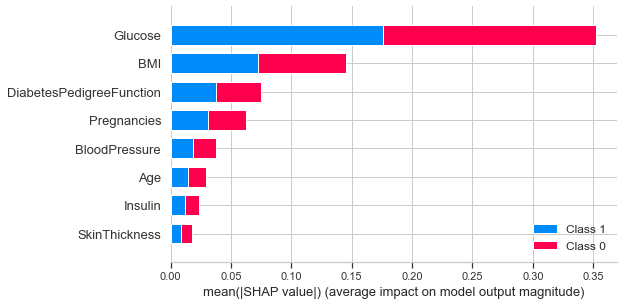

In [42]:
# explain all the predictions in the test set
explainer = shap.TreeExplainer(forest_clf)
shap_values = explainer.shap_values(strat_test_set)
shap.summary_plot(shap_values, strat_test_set)

In [44]:
# explain all the predictions in the test set
explainer = shap.KernelExplainer(forest_clf.predict_proba, diabetes_train)
shap_values = explainer.shap_values(strat_test_set)
shap.force_plot(explainer.expected_value[0], shap_values[0], strat_test_set)

Using 576 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


KeyboardInterrupt: 

# Logistic Regression

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict



clf = LogisticRegression(random_state=RANDOM_SEED)



y_scores = cross_val_predict(
    clf,
    diabetes_train,
    diabetes_labels,
    cv=3,
    n_jobs=-1,
)




y_scores


array([1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,

In [46]:
from sklearn.metrics import accuracy_score


clf.fit(diabetes_train, diabetes_labels)


y_pred=clf.predict(strat_test_set)

acc = accuracy_score(y_test, y_pred)
print('Regressão logistica: acurácia = {:.2f}'.format(acc))

Regressão logistica: acurácia = 0.39


After using the Logistic Regression it is possible to conclude that its performance is the same as the SGD classifier, with an insufficient accuracy of only 34%. 

# SVM

In [47]:
from sklearn.svm import LinearSVC, SVC

clf_svm= SVC(C=1e5, kernel='rbf', degree=7,  random_state=RANDOM_SEED)
clf_svm.fit(diabetes_train, diabetes_labels)

SVC(C=100000.0, degree=7, random_state=42)

In [48]:
%%time
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from pprint import pprint

grid = GridSearchCV(
    clf_svm,
    {
        'C': [10.0**k for k in np.arange(-3, 1, 1)], 'kernel': ('linear', 'rbf')
    },
    scoring='accuracy',
    cv=ShuffleSplit(
        n_splits=100,
        test_size=0.33,
        random_state=RANDOM_SEED,
    ),
    n_jobs=-1,
    verbose=3,
)
# len(clf_svm.get_params().keys())
grid.fit(diabetes_train, diabetes_labels)

print(grid.best_params_)



Fitting 100 folds for each of 8 candidates, totalling 800 fits
{'C': 0.1, 'kernel': 'linear'}
CPU times: user 950 ms, sys: 64.8 ms, total: 1.01 s
Wall time: 11.2 s


C = 0.00100: mean_accuracy = 0.667, stddev_accuracy = 0.026
C = 0.00100: mean_accuracy = 0.667, stddev_accuracy = 0.026
C = 0.01000: mean_accuracy = 0.768, stddev_accuracy = 0.025
C = 0.01000: mean_accuracy = 0.667, stddev_accuracy = 0.026
C = 0.10000: mean_accuracy = 0.768, stddev_accuracy = 0.022
C = 0.10000: mean_accuracy = 0.701, stddev_accuracy = 0.042
C = 1.00000: mean_accuracy = 0.768, stddev_accuracy = 0.024
C = 1.00000: mean_accuracy = 0.762, stddev_accuracy = 0.023


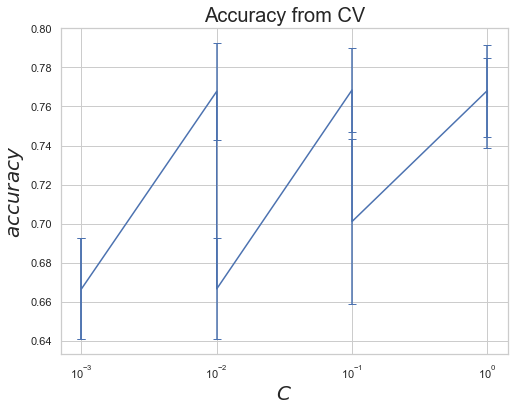

In [49]:
P = np.array([p['C'] for p in grid.cv_results_['params']])
M = grid.cv_results_['mean_test_score']
S = grid.cv_results_['std_test_score']

for p, m, s in zip(P, M, S):
    print(f'C = {p:.5f}: mean_accuracy = {m:.3f}, stddev_accuracy = {s:.3f}')

plt.figure(figsize=(8, 6))
plt.errorbar(P, M, S, capsize=4)
plt.semilogx()
plt.title('Accuracy from CV', fontsize=20)
plt.xlabel(r"$C$", fontsize=20)
plt.ylabel(r"$accuracy$", fontsize=20)
plt.show()

The idea of SVM algorithm is to trace a curve that can separate when a patient has diabets. However, sometimes the samples are mixed and a curve that completely separates those values is not possible. To calculate the best curve possible, the C parameter used in the algorithm associate penalties to the values that are miscalculated.